# Initialization

In [1]:
###############################################################################
#
#Importing libraries
#
import pandas as pd 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,ENGLISH_STOP_WORDS,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, f1_score, recall_score
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb 
import seaborn as sns
###############################################################################
#
#Notebook options
#
%matplotlib inline
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
###############################################################################

# Data import

In [2]:
apple = pd.read_csv(r'../Data/AAPL.csv')
apple.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,News
0,12/1/2006,13.114285,13.190000,12.871428,91.320000,13.045714,198769900,WHAT'S ON TONIGHT : 8 P.M. (TLC) ASHLEY JUDD A...
1,12/4/2006,13.125714,13.150000,12.928572,91.120003,13.017143,177384200,More on Housing Prices : The broadest governme...
2,12/6/2006,12.948571,13.055715,12.810000,89.830002,12.832857,159546100,Honoring R.W. Apple in Words and Food : About ...
3,12/7/2006,12.861428,12.928572,12.414286,87.040001,12.434286,251206900,"Homebuilders, and Worries Over Jobs, Lead a De..."
4,12/8/2006,12.461429,12.770000,12.428572,88.259995,12.608571,196069300,"Homebuilders, and Worries Over Jobs, Lead a De..."


# Data exploration

In [3]:
# Creating a corpus of all the news
sents=[]
apple_news=''

sents=[sent for sent in apple.News]
for j in range(len(sents)):
    apple_news=apple_news+str(sents[j])

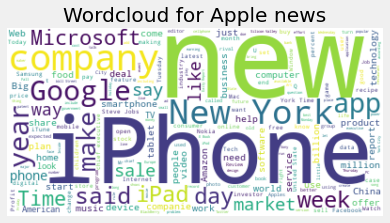

In [4]:
# Creating wordcloud of all the news

apples=WordCloud(stopwords=ENGLISH_STOP_WORDS.union(['Apple','S']), background_color='white').generate(apple_news)

plt.title('Wordcloud for Apple news')
plt.imshow(apples,interpolation='bilinear')
plt.axis('off')
plt.show()

# Data preparation

In [5]:
# Creating target feature
apple['Bullish']=(apple.Close>apple.Open).astype('int')
# Dropping all stock data
apple.drop(['Date','Open','High','Low','Close','Adj Close','Volume'],axis=1,inplace=True)

# Feature extraction

In [6]:
# Instantiating CountVectorizer object
cnt1=TfidfVectorizer(lowercase=True, stop_words=ENGLISH_STOP_WORDS.union('s'),token_pattern=r"\w+", ngram_range=(1,5),max_features=200, min_df=2)

In [7]:
# Creating feature and target dataframes
apple_x=apple.News
apple_y=apple.Bullish

# Model building

In [8]:
# Creating train and test split
apple_X_train,apple_X_test, apple_y_train, apple_y_test=train_test_split(apple_x,apple_y, test_size=0.2, random_state=12345)

# Fitting the cnt1 object on the training data
apple_X_train = pd.DataFrame(cnt1.fit_transform(apple_X_train).A,columns=cnt1.get_feature_names())

# Transforming the test data using the fitted cnt1 object
apple_X_test = pd.DataFrame(cnt1.transform(apple_X_test).A,columns=cnt1.get_feature_names())

In [9]:
###############################################################################
#
# def scorer(model,X_train,X_test,y_train,y_test):
# 
# Inputs:
# model: XGBoost etc.
# X_train=training feature set
# X_test=test feature set
# y_train=training target set
# y_test=test target set
#
# 1. Fit the model on the data
# 2. Generate the predictions using the fitted model
# 3. Calculate the accuracy, precision, recall and F1 score
#  
###################################################################################

def scorer(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    predictions=model.predict(X_test)
    acc = accuracy_score(y_test,predictions)
    prec= precision_score(y_test,predictions)
    rec=recall_score(y_test,predictions)
    f1=f1_score(y_test,predictions)
    return acc,prec,rec,f1

## Rule based sentiment analysis

In [10]:
# Instantiating the models' objects

LR=LogisticRegression(solver='liblinear')
KNNC=KNeighborsClassifier(n_neighbors=2)
SV=SVC(kernel='poly')
DTC=DecisionTreeClassifier(max_depth=8, class_weight={0:2,1:1.45}, max_features="sqrt",random_state=1234)
RF=RandomForestClassifier(class_weight={0:2,1:1.45},n_estimators=50, random_state=123456)
GBM=GradientBoostingClassifier(learning_rate= 0.4, max_depth= 2, max_features='auto', n_estimators= 150, random_state=12345)
ADA=AdaBoostClassifier()

In [11]:
# Finding the best alpha value for Bernoulli NB

scr=[]
for i in np.arange(0.1,10,0.1):
    scr.append([scorer(BernoulliNB(alpha=i),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])

pos=np.array(scr).mean(axis=2).argmax()
alp=0.1+0.1*pos
B=BernoulliNB(alpha=alp)

In [12]:
# Finding the best alpha value for Bernoulli NB

scr=[]
for i in np.arange(0.1,10,0.1):
    scr.append([scorer(GaussianNB(var_smoothing=i),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])

pos=np.array(scr).mean(axis=2).argmax()
alp=0.1+0.1*pos
G=GaussianNB(var_smoothing=alp)

In [13]:
# Testpad for setting the hyper parameters
'''
from sklearn.model_selection import GridSearchCV
gg=GridSearchCV(GradientBoostingClassifier(),param_grid={"learning_rate":np.arange(0.1,0.5,0.1), "n_estimators":np.arange(50,250,50),"max_depth":np.arange(2,6,2),"max_features":["auto", "sqrt", "log2"]}, scoring='precision',cv=5)
gg.fit(apple_X_train,apple_y_train)
gg.best_params_
'''

'\nfrom sklearn.model_selection import GridSearchCV\ngg=GridSearchCV(GradientBoostingClassifier(),param_grid={"learning_rate":np.arange(0.1,0.5,0.1), "n_estimators":np.arange(50,250,50),"max_depth":np.arange(2,6,2),"max_features":["auto", "sqrt", "log2"]}, scoring=\'precision\',cv=5)\ngg.fit(apple_X_train,apple_y_train)\ngg.best_params_\n'

In [14]:
# Running all the models

logistic=pd.Series([*scorer(LR,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
knn=pd.Series([*scorer(KNNC,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
svm=pd.Series([*scorer(SV,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
nb=pd.Series([*scorer(B,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
gnb=pd.Series([*scorer(G,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
tree=pd.Series([*scorer(DTC,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
rf=pd.Series([*scorer(RF,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
ada=pd.Series([*scorer(ADA,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
gbm=pd.Series([*scorer(GBM,apple_X_train,apple_X_test,apple_y_train,apple_y_test)])

In [15]:
# Printing the scoring matrix

scores=pd.DataFrame({"Logistic":logistic,'KNN':knn,'SVM':svm,'BernoulliNB':nb,"GaussianNB":gnb,"DecisionTree":tree,"Random Forest":rf,"Adaboost":ada,"GBM":gbm})
scores.index=['Accuracy','Precision','Recall','F1 score']
scores.transpose().sort_values(['F1 score','Precision'], ascending=False)

,Accuracy,Precision,Recall,F1 score
GaussianNB,0.913978,0.913978,1.000000,0.955056
Random Forest,0.911828,0.913793,0.997647,0.953881
Logistic,0.901075,0.914661,0.983529,0.947846
SVM,0.898925,0.914474,0.981176,0.946652
Adaboost,0.877419,0.922018,0.945882,0.933798
DecisionTree,0.866667,0.921114,0.934118,0.927570
GBM,0.862366,0.913043,0.938824,0.925754
BernoulliNB,0.853763,0.936430,0.901176,0.918465
KNN,0.823656,0.931990,0.870588,0.900243


We'll use GBM based on the above table as it scores >=90 in precision recall and F1 score. Also, a very high recall and stagnant precision score indicates that those models predict the negative class for almost all the observations in the test set

In [16]:
confusion_matrix(apple_y_test,GBM.predict(apple_X_test))

array([[  2,  38],
       [ 26, 399]], dtype=int64)

## Automated sentiment analysis

In [17]:
# Creating the sentiments for all the news

#I have obtained the sentiment = polarity * objectivity where objectivity=1-subjectivity

sentiments=pd.Series([])
for i in range(len(apple_x)):
    t=TextBlob(apple.News.iloc[i])
    sentiments[i]=t.sentiment[0]*(1-t.sentiment[1])

<ipython-input-17-f7b79a82e57b>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sentiments=pd.Series([])


In [18]:
# Doing a sigmoid transformation to get the values between 0 and 1

sentiments=1/(1+np.exp(-sentiments))

c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

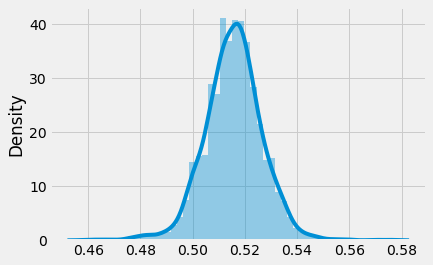

In [19]:
sns.distplot(sentiments)

In [20]:
#Using a threshold of 0.5. This can be adjusted to get better result when more data is available
predictionp=sentiments>0.50

In [21]:
print("F1 score: ",f1_score(apple.Bullish,predictionp))
print("Precision: ",precision_score(apple.Bullish,predictionp))
print("Accuracy: ",accuracy_score(apple.Bullish,predictionp))

F1 score:  0.905885156063855
Precision:  0.8837749883774988
Accuracy:  0.8299612569952648


In [22]:
confusion_matrix(apple.Bullish,predictionp)

array([[  27,  250],
       [ 145, 1901]], dtype=int64)

As we can see there isn't much difference in overall performance by using lexicon based sentiment analysis for apple's news stream

Also note that we do not need to train any model. This will be very useful where cold start is a problem.